In [ ]:
!pip install rsome
!pip install mosek
!rm mosek.lic
!git clone https://github.com/erickdelage/80624
!cp ./80624/mosek.lic .
!rm -r ./80624
!mkdir -p /root/mosek
!cp ./mosek.lic /root/mosek
!pip install -i https://pypi.gurobi.com gurobipy

Cloning into '80624'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.
Looking in indexes: https://pypi.gurobi.com


In [ ]:
import rsome as rso
import numpy as np
from rsome import ro
from rsome import msk_solver as my_solver  #Import Mosek solver interface
# from rsome import grb_solver as my_solver  #Import Gurobi solver interface

import random
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Synthetic Data for Robust Model

In [ ]:
# Number of cars
ncar = 10

# Number of sequences
nseq = ncar

# Estimated values by seller
v = np.array([20, 21, 24, 22.5, 28, 20.6, 23.4, 25.4, 18.4, 14])*1000

# Nominal prices (NOTE: the starting prices used in this study correspond to the 
# prices presented for cars 1 to 10, in sequences 1 to 10 of the larger data set
# of Ma et al. 2021)
p0 = np.array(
    [[20.5, 23.1, 23.6, 22.8, 21.5, 20.8, 23.7, 20.2, 21.8, 23.3],
     [20.4, 22.5, 25.5, 22.6, 24.4, 21.2, 21.4, 23.6, 23.1, 23.0],
     [27.6, 26.1, 26.9, 33.7, 30.8, 24.2, 25.3, 24.7, 26.3, 24.2],
     [22.3, 24.5, 24.7, 23.5, 22.5, 24.3, 23.6, 23.4, 23.7, 24.7],
     [28.5, 33.4, 29.5, 27.1, 28.5, 28.5, 30.2, 32.9, 31.8, 34.1],
     [26.9, 25.8, 26.3, 23.6, 27.3, 22.4, 22.5, 24.4, 26.8, 22.2],
     [29.9, 27.5, 19.2, 28.7, 27.9, 24.2, 24.8, 24.9, 25.9, 23.7],
     [29.2, 30.9, 27.3, 28.2, 29.5, 26.4, 26.9, 27.8, 29.1, 26.1],
     [20.8, 24.0, 23.7, 24.6, 22.1, 20.4, 20.1, 19.9, 23.3, 20.2],
     [19.2, 18.7, 19.3, 20.1, 19.2, 15.6, 20.4, 17.3, 21.3, 22.7]])*1000

In [ ]:
boot = 25
y = np.zeros((ncar, ncar, boot))
X = []
for c in range(ncar):
    temp_X = []
    for p in range(ncar):
        temp_temp_X = []
        for b in range(boot):
            # random integer to determine variance
            r = np.random.randint(low=1, high=10)
            # np.random.seed([1])
            tilde = np.random.normal(loc=p0[c][p], scale=(r*1000))
            y[c][p][b] = tilde

            if p == 0:
                temp_temp_X.append(np.zeros(ncar-1))
            else:
                r1 = random.sample(list(np.arange(ncar-1)), p)
                tmp = np.zeros(ncar-1)
                for num in r1:
                    tmp[num] = 1
                temp_temp_X.append(tmp)

        temp_X.append(temp_temp_X)
    X.append(temp_X)

In [ ]:
def regression(y, X):
    model = sm.OLS(y, sm.add_constant(X))
    res = model.fit()

    coeffs = res.params 
    coeffs_stdev = res.bse
        
    return coeffs, coeffs_stdev

In [ ]:
coeff_dat = []
stdev_dat = []
for c1 in range(ncar):
    temp_y = y[c1,:,:].reshape(-1,1)
    temp_X = X[c1]

    temp_X_flat = []
    for dat in temp_X:
      for sub_dat in dat:
        temp_X_flat.append(sub_dat)

    temp_coeffs, temp_stdev = regression(temp_y, temp_X_flat)
    coeff_dat.append(temp_coeffs)
    stdev_dat.append(temp_stdev)

In [ ]:
coeff0 = np.zeros(ncar)
coeff_delta = np.zeros((ncar,ncar))
stdev_delta = np.zeros((ncar,ncar))

for c2 in range(ncar):
    coeff0[c2] = coeff_dat[c2][0]
    temp_coeffs = np.delete(coeff_dat[c2],0)
    coeff_delta[c2] = np.insert(temp_coeffs, c2, 0)
    temp_stdev = np.delete(stdev_dat[c2],0)
    stdev_delta[c2] = np.insert(temp_stdev, c2, 0)

In [ ]:
coeff0

array([21901.04942612, 21834.79145589, 28169.38609105, 23965.17150251,
       28408.59555014, 25828.4008874 , 26998.82120947, 28548.53467845,
       24011.44202244, 19249.79870178])

In [ ]:
coeff_delta

array([[    0.        ,    86.68221198,   514.72491638,  -128.59438962,
           44.04429422,  -390.77079393,  -956.10083265,   728.46369854,
         -523.50974775,   370.76291201],
       [ -762.3536081 ,     0.        ,   922.66096037,  1013.41380973,
         1943.52308685,  -158.6813292 , -1203.54616905,   163.58142523,
          723.80437074, -1487.91377884],
       [  706.2382528 ,   203.98248388,     0.        , -1404.13115271,
        -1890.23598894, -1650.18421514,   808.00887924,   712.50708963,
          249.85042029,  -722.62540072],
       [  487.74949552,  1120.93904611,  -406.57574849,     0.        ,
         -128.88484506,  1120.83794124,  -743.09765288,  -670.40110041,
        -1505.48737666,  1051.66196323],
       [ 2005.42894345,   484.18589864,  -356.44573244,  -573.16218746,
            0.        ,   276.09122468,    75.57218059,     7.16748658,
         2592.88206921,   155.03338656],
       [-1277.48162023,  1245.20612459,   473.5585292 , -1962.53575829,
   

In [ ]:
stdev_delta

array([[   0.        ,  791.6871124 ,  780.66086482,  777.23751318,
         733.88756172,  783.25860802,  805.42042981,  789.35017764,
         806.71475395,  777.85108508],
       [ 858.57163064,    0.        ,  852.72131504,  824.60511704,
         874.39404108,  820.89633993,  902.23710322,  865.40456729,
         864.34628569,  863.1533039 ],
       [1001.57737179,  988.50343616,    0.        ,  973.31578595,
         927.95822414,  988.40951298,  949.67715231,  915.53407662,
         912.16390348,  966.80497384],
       [ 878.31217664,  920.22658186,  908.72571547,    0.        ,
         957.15631864,  958.05471533,  882.6854873 ,  927.92145769,
         919.49672458,  909.21455759],
       [ 802.19688245,  831.29146965,  785.07310791,  842.66700647,
           0.        ,  777.91967188,  776.5267176 ,  779.28128718,
         810.27283089,  780.71665332],
       [ 940.03146678,  970.16702858,  948.80893835, 1006.92299152,
        1019.5388749 ,    0.        ,  975.25532931,  927

## Nominal Model

The nominal model is 
\begin{align*}
    \max_{x, r, w, y} \hspace{5mm} & \sum_{i=1}^n \left(r_{i} - v_{i} \right) & \\
    s.t. \hspace{5mm} & r_{i} \leq \sum_{t=1}^{n} \left( p_{i}^{0} x_{it} + \sum_{k=1}^{n} \delta_{ik} y_{ikt} \right) & \forall i \in I \\
    & \sum_{t=1}^n x_{it} = 1 & \forall i \in I \\
    &\sum_{i=1}^n x_{it} = 1 & \forall t \in T \\
    & \sum_{k=1}^{n} w_{ik} \leq \sum_{t=1}^{n} t x_{it} - 1 & \forall i\in I \\
    & w_{ik} + w_{ki} \leq 1 & \forall i \in I, \hspace{2mm} \forall k \in I \\
    & w_{ik} = 0 & \forall i = k \in I\\
    & y_{ikt} \leq w_{ik} & \forall i \in I, \forall k \in I, \forall t \in T\\
    & y_{ikt} \leq x_{it} & \forall i \in I, \forall k \in I, \forall t \in T\\
    & y_{ikt} \geq w_{ik} + x_{it} - 1 & \forall i \in I, \forall k \in I, \forall t \in T\\
    &  x_{it} \in \{0, 1\} & \forall i \in I, \forall t \in T \\
    & w_{ik} \in \{0, 1\}  & \forall i \in I, \forall k \in I \\
    & y_{ikt} \in \{0, 1\} & \forall i \in I, \forall k \in I ,\forall t \in T
\end{align*}

In [ ]:
def nominal():
    model = ro.Model('nomial')

    # Define decision variables
    r = model.dvar(ncar)
    x = model.dvar((ncar, nseq), vtype='B')
    w = model.dvar((ncar, ncar), vtype='B')
    y = model.dvar((ncar, nseq, ncar), vtype='B')

    # objective function
    model.max((r - v).sum())

    # constraints
    for i in range(ncar):
        model.st(
            r[i] <= (coeff0[i]*x[i]).sum() + (coeff_delta[i]*w[i]).sum()
        )
        # r[i] <= (coeff0[i]*x[i]).sum() + (y[i] @ coeff_delta[i]).sum()
    model.st(x.sum(axis=0) == np.ones(ncar))
    model.st(x.sum(axis=1) == np.ones(nseq))
    model.st(w.T + w <= 1)
    for i1 in range(ncar):
        model.st(w[i1].sum() == (x[i1]*np.arange(1,nseq+1)).sum() - 1)
        model.st(w[i1,i1] == 0)
    # for t in range(ncar):
    #     model.st(w >= y[:,t,:])
    # for k in range(nseq):
    #     model.st(x >= y[:,:,k])
    # for i2 in range(ncar):
    #     for t1 in range(nseq):
    #         for k1 in range(ncar):
    #             model.st(y[i2,t1,k1] >= (x[i2,t1] + w[i2,k1]) - 1)
      
    # solve model
    model.solve(my_solver)

    return model.get(), x.get(), w.get(), y.get(), r.get()

In [ ]:
opt_nom, x_nom, w_nom, y_nom, r_nom = nominal()
opt_nom

Being solved by Mosek...
Solution status: integer_optimal
Running time: 6.4828s


44121.8710034963

In [ ]:
nom_ord = []
for nom_row in x_nom:
    nom_ord.append(round((nom_row * np.arange(1, ncar+1)).sum()))

nom_ord

[5, 3, 2, 6, 9, 4, 8, 10, 1, 7]

## Sequential Robust Auction (SRA) Model (linear combination of regression coefficient and thier variance)

In [ ]:
def SAR(gamma):
    model = ro.Model('SAR')

    # Define decision variables
    r = model.dvar(ncar)
    x = model.dvar((ncar, nseq), vtype='B')
    w = model.dvar((ncar, ncar), vtype='B')
    y = model.dvar((ncar, nseq, ncar), vtype='B')
    
    # Uncertain variable and Uncertainty set
    z = model.rvar(nseq)
    U = (rso.norm(z,2)<=gamma)

    # objective function
    model.max((r - v).sum())

    # constraints
    for i in range(ncar):
        model.st(
            ( r[i] <= (coeff0[i]*x[i]).sum() + (coeff_delta[i]*w[i]).sum() - (stdev_delta[i]*w[i]*z).sum() ).forall(U)
        )
        # ( r[i] <= (coeff0[i]*x[i]).sum() + (y[i] @ coeff_delta[i]).sum() - (y[i] @ (stdev_delta[i]*z)).sum() ).forall(U)
    model.st(x.sum(axis=0) == np.ones(ncar))
    model.st(x.sum(axis=1) == np.ones(nseq))
    model.st(w.T + w <= 1)
    for i1 in range(ncar):
        model.st(w[i1].sum() == (x[i1]*np.arange(1,nseq+1)).sum() - 1)
        model.st(w[i1,i1] == 0)
    # for t in range(ncar):
    #     model.st(w >= y[:,t,:])
    # for k in range(nseq):
    #     model.st(x >= y[:,:,k])
    # for i2 in range(ncar):
    #     for t1 in range(nseq):
    #         for k1 in range(ncar):
    #             model.st(y[i2,t1,k1] >= (x[i2,t1] + w[i2,k1]) - 1)
      
    # solve model
    model.solve(my_solver)

    return model.get(), x.get(), w.get(), r.get(), y.get()

In [ ]:
epsilon = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

obj_res = np.zeros(len(epsilon))
x_res = np.zeros((len(epsilon), ncar, nseq))
w_res = np.zeros((len(epsilon), ncar, nseq))
for e in range(len(epsilon)):
    temp_z_score = stats.norm.ppf(1-epsilon[e])
    temp_obj, temp_x, temp_w, temp_r, temp_y = SAR(temp_z_score)
    obj_res[e] = temp_obj
    x_res[e] = temp_x
    w_res[e] = temp_w

Being solved by Mosek...
Solution status: integer_optimal
Running time: 37.3281s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 25.6790s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 41.1355s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 47.9722s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 29.5035s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 51.2578s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 37.7754s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 30.3422s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 29.6915s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 43.4921s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 39.8689s


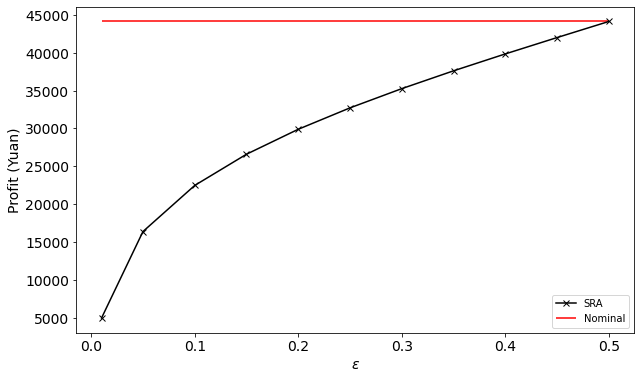

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(epsilon, obj_res, '-kx', label='SRA')
plt.hlines(opt_nom, epsilon[0], epsilon[-1], color='r', label='Nominal')
plt.xlabel('$\epsilon$', fontsize=14)  # , fontsize=20
plt.xticks(fontsize=14)
plt.ylabel('Profit (Yuan)', fontsize=14)  # , fontsize=20
plt.yticks(fontsize=14)
plt.legend(loc="lower right")
plt.savefig('results.pdf')
plt.show()

In [ ]:
# ordering
ord = []
for e2 in range(len(epsilon)):
    temp_x_res = x_res[e2]
    temp_ord = []
    for row in temp_x_res:
        temp_ord.append(round((row * np.arange(1, nseq+1)).sum()))
    ord.append(temp_ord)

In [ ]:
print('',nom_ord)
print('')
ord

 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7]



[[6, 4, 3, 7, 10, 5, 9, 1, 2, 8],
 [6, 4, 3, 7, 10, 5, 9, 1, 2, 8],
 [6, 4, 3, 7, 10, 5, 9, 1, 2, 8],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7],
 [5, 3, 2, 6, 9, 4, 8, 10, 1, 7]]

In [ ]:
print(opt_nom)
print('')
obj_res

44121.8710034963



array([ 4945.94318522, 16368.94238035, 22458.50098303, 26581.66678114,
       29878.5935634 , 32707.06317865, 35247.11631068, 37600.85408108,
       39834.32105268, 41995.22619541, 44121.8710035 ])